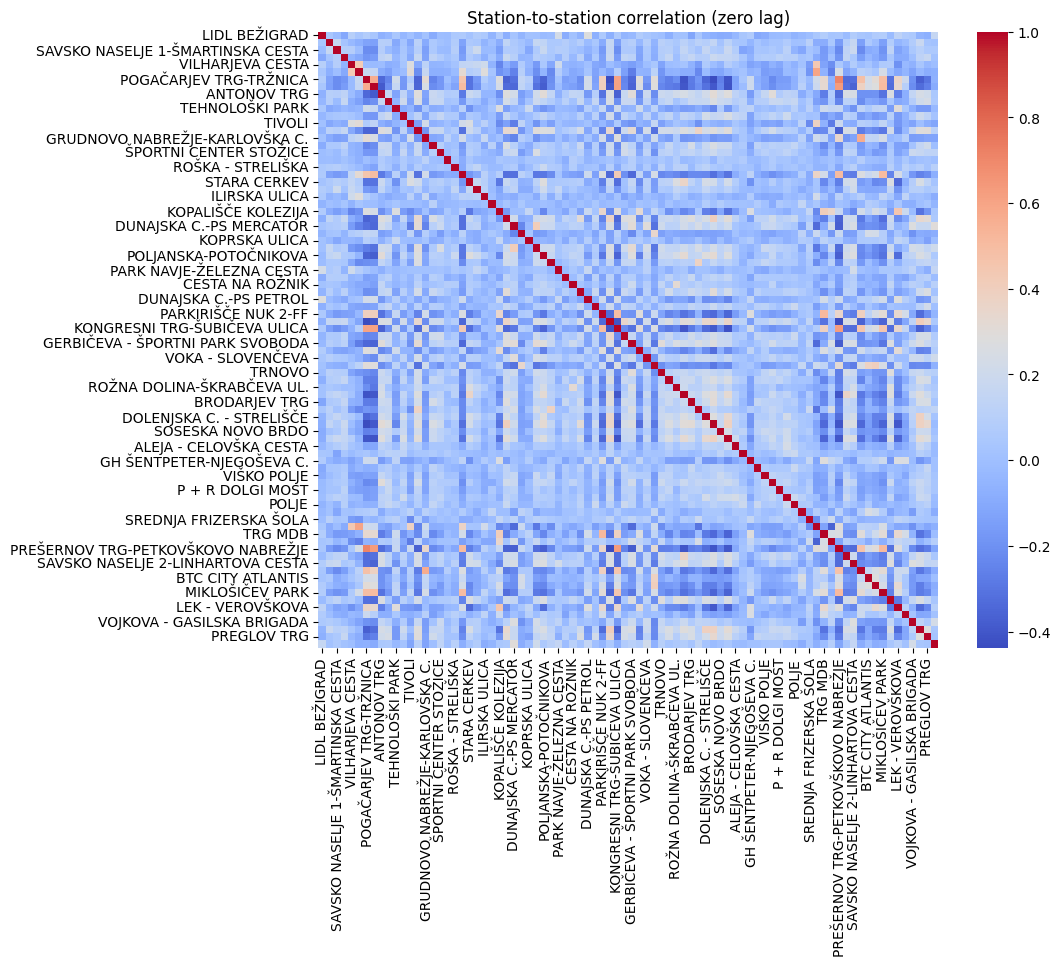

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/bicikelj_train.csv')
station_cols = df.columns[1:]
data = df[station_cols].astype(float)

# Zero-lag correlation matrix
corr_matrix = data.corr()

# Optionally, show as heatmap
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title("Station-to-station correlation (zero lag)")
plt.show()


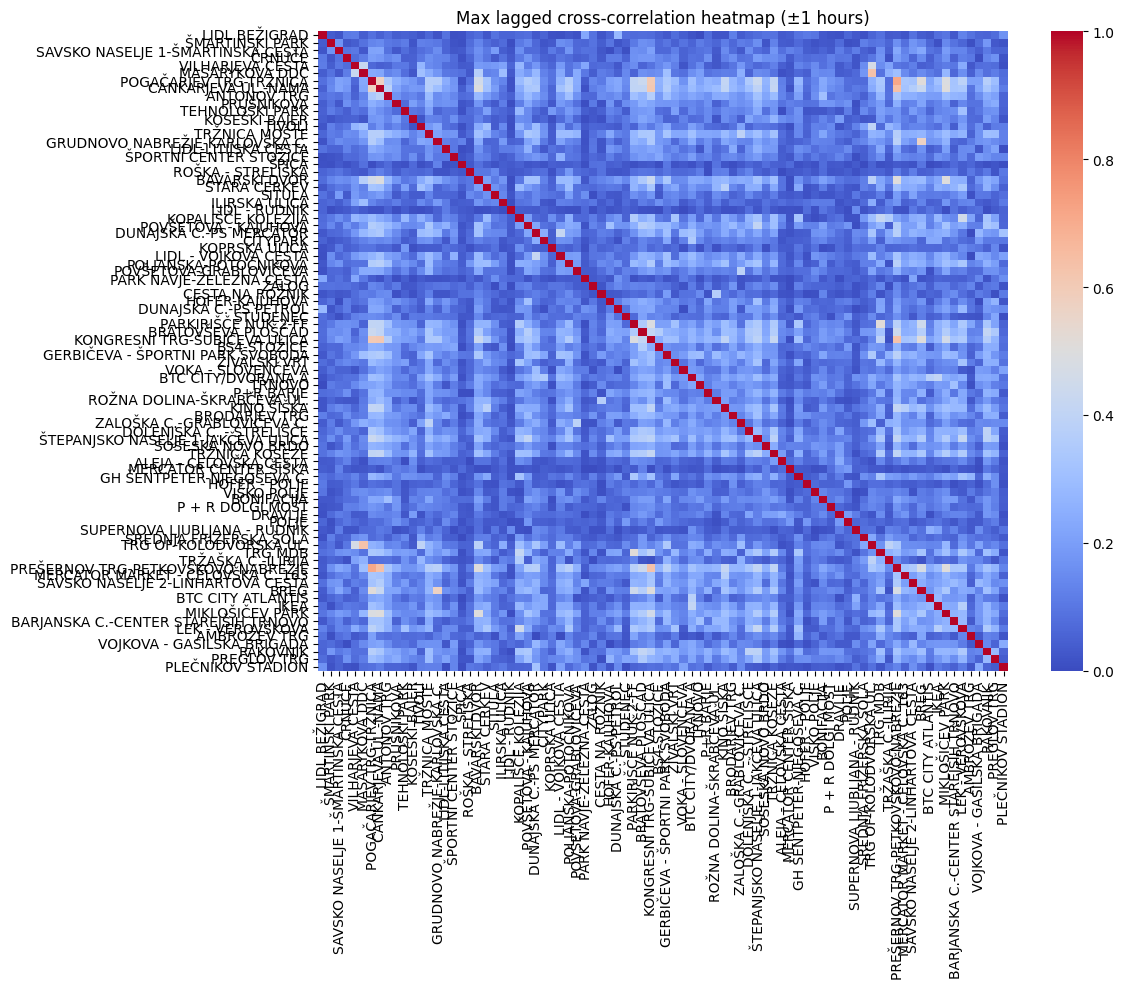

In [9]:
import numpy as np
# Assuming the first column is timestamp, rest are stations


def max_cross_corr_lag(x, y, max_lag=1, min_overlap=10):
    """Return the max abs cross-correlation over lags [-max_lag, +max_lag] with enough overlap."""
    lags = range(-max_lag, max_lag + 1)
    corrs = []
    n = len(x)
    for lag in lags:
        if lag < 0:
            x1 = x[:lag]
            y1 = y[-lag:]
        elif lag > 0:
            x1 = x[lag:]
            y1 = y[:-lag]
        else:
            x1 = x
            y1 = y
        if len(x1) >= min_overlap and len(y1) >= min_overlap:
            c = np.corrcoef(x1, y1)[0, 1]
            corrs.append(c)
    if corrs:
        return np.nanmax(np.abs(corrs))
    else:
        return 0.0  # If no valid lags, treat as uncorrelated

import pandas as pd
df = pd.read_csv('../data/bicikelj_train.csv')
station_cols = df.columns[1:]
for col in station_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df[station_cols] = df[station_cols].fillna(0)
data = df[station_cols].astype(float).values

num_stations = len(station_cols)
max_lag = 1
corr_matrix_lagged = np.zeros((num_stations, num_stations))

for i in range(num_stations):
    for j in range(num_stations):
        if i == j:
            corr_matrix_lagged[i, j] = 1.0
        else:
            xi = data[:, i]
            xj = data[:, j]
            corr_matrix_lagged[i, j] = max_cross_corr_lag(xi, xj, max_lag=max_lag)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix_lagged, 
            xticklabels=station_cols, 
            yticklabels=station_cols, 
            cmap='coolwarm', vmin=0, vmax=1)
plt.title(f"Max lagged cross-correlation heatmap (±{max_lag} hours)")
plt.tight_layout()
plt.show()


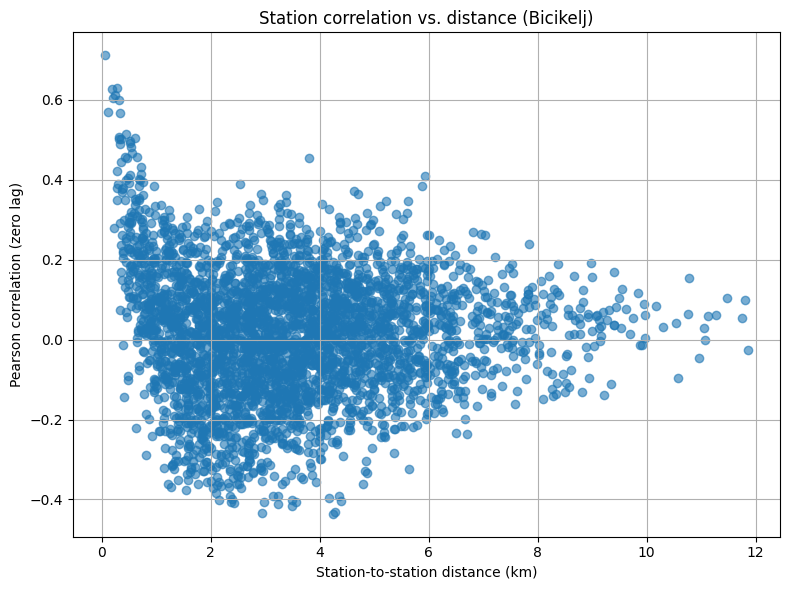

Correlation between pairwise distance and correlation: -0.040


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances

# --- Load and clean data ---
train_df = pd.read_csv('../data/bicikelj_train.csv')
meta_df = pd.read_csv('../data/bicikelj_metadata.csv')

station_cols = train_df.columns[1:]

# Clean bike count columns: numeric, fill NaN with 0
for col in station_cols:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
train_df[station_cols] = train_df[station_cols].fillna(0)

# --- Ensure station order in metadata matches data columns ---
# If needed: reindex meta_df to match order of station_cols
meta_df = meta_df.set_index('name')
meta_df = meta_df.loc[station_cols].reset_index()  # order guaranteed

# --- Compute station coordinates in radians for haversine ---
coords = np.deg2rad(meta_df[['latitude', 'longitude']].values)

# --- Compute pairwise haversine distances (km) ---
dists = haversine_distances(coords, coords) * 6371  # Earth's radius in km

# --- Compute zero-lag correlation matrix ---
data = train_df[station_cols].values
corr_matrix = np.corrcoef(data.T)

# --- Flatten for scatterplot (exclude diagonal) ---
n = len(station_cols)
flat_corr = corr_matrix[np.triu_indices(n, k=1)]
flat_dist = dists[np.triu_indices(n, k=1)]

# --- Scatter plot: correlation vs. distance ---
plt.figure(figsize=(8,6))
plt.scatter(flat_dist, flat_corr, alpha=0.6)
plt.xlabel('Station-to-station distance (km)')
plt.ylabel('Pearson correlation (zero lag)')
plt.title('Station correlation vs. distance (Bicikelj)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: calculate and print correlation between corr and distance
pearson_corr = np.corrcoef(flat_dist, flat_corr)[0,1]
print(f"Correlation between pairwise distance and correlation: {pearson_corr:.3f}")


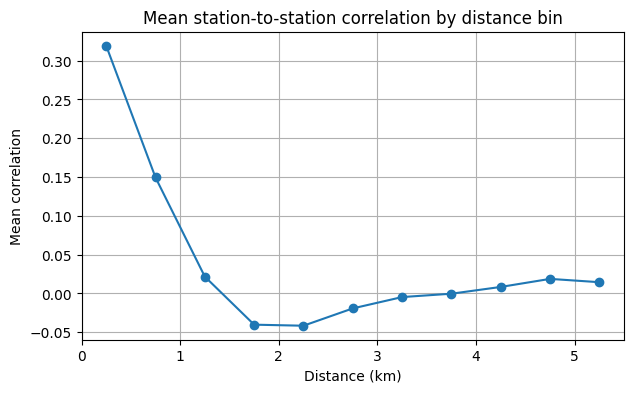

In [12]:
import numpy as np
import matplotlib.pyplot as plt

bins = np.arange(0, 6, 0.5)  # 0, 0.5, 1, ..., 5.5
bin_indices = np.digitize(flat_dist, bins)
bin_means = [flat_corr[bin_indices == i].mean() if np.any(bin_indices == i) else np.nan for i in range(1, len(bins))]
plt.figure(figsize=(7,4))
plt.plot(bins[:-1]+0.25, bin_means, marker='o')
plt.xlabel("Distance (km)")
plt.ylabel("Mean correlation")
plt.title("Mean station-to-station correlation by distance bin")
plt.grid(True)
plt.show()


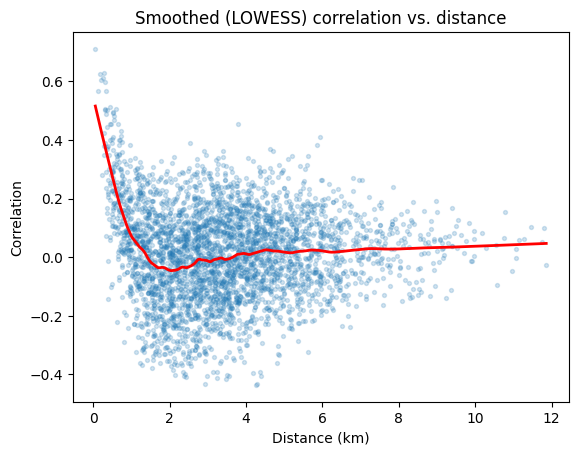

In [14]:
from statsmodels.nonparametric.smoothers_lowess import lowess
filtered = lowess(flat_corr, flat_dist, frac=0.1)
plt.scatter(flat_dist, flat_corr, alpha=0.2, s=8)
plt.plot(filtered[:,0], filtered[:,1], color='red', linewidth=2)
plt.xlabel('Distance (km)')
plt.ylabel('Correlation')
plt.title('Smoothed (LOWESS) correlation vs. distance')
plt.show()


In [15]:
near = flat_corr[flat_dist < 1]
far = flat_corr[flat_dist >= 1]
print("Mean corr (near):", near.mean())
print("Mean corr (far):", far.mean())
from scipy.stats import ttest_ind
print("t-test:", ttest_ind(near, far, equal_var=False))


Mean corr (near): 0.1844693255519464
Mean corr (far): -0.002043916377546304
t-test: TtestResult(statistic=16.625216369547008, pvalue=6.702801453839566e-44, df=286.09714995491186)


In [ ]:
import matplotlib.pyplot as plt

# Validation loss arrays
comb1 = [10.44, 10.21, 9.94, 10.07, 10.00, 9.86, 9.71, 9.69, 10.06, 9.58, 9.56, 9.55, 9.64, 9.80, 9.50, 9.52, 9.51, 9.49, 9.52, 9.54]
comb2 = [13.48, 12.15, 11.65, 11.32, 11.13, 10.91, 10.65, 10.52, 10.41, 10.26, 10.25, 10.24, 10.17, 10.15, 10.12, 10.12, 10.07, 9.97, 10.04, 10.01, 10.04, 9.91, 9.88, 9.79, 9.80, 9.80, 9.74, 9.71, 9.66, 9.71, 9.77, 9.66, 9.60, 9.75, 9.61, 9.63, 9.55, 9.59, 9.61, 9.52, 9.69, 9.73, 9.54, 9.49, 9.56, 9.53, 9.57, 9.50, 9.50]
comb3 = [11.70, 11.00, 10.49, 10.27, 10.05, 10.01, 9.85, 9.84, 9.65, 9.76, 9.79, 9.63, 9.64, 9.53, 9.53, 9.62, 9.47, 9.55, 9.42, 9.39, 9.58, 9.49, 9.40, 9.40, 9.48, 9.45, 9.45, 9.38]
comb4 = [11.14, 10.57, 10.34, 10.22, 10.12, 10.11, 10.02, 9.99, 9.99, 9.81, 10.00, 9.79, 9.73, 9.67, 9.90, 9.61, 9.79, 9.75, 9.65, 9.65, 9.53, 9.47, 9.74, 9.50, 9.68, 9.79, 9.63]
comb5 = [10.51, 10.05, 10.10, 9.90, 10.01, 9.76, 9.82, 9.61, 9.58, 9.61, 9.86, 9.62, 9.52, 9.52, 9.55, 9.39, 9.45, 9.42, 9.39, 9.26, 9.40, 9.31, 9.35, 9.25, 9.42]

# Holdout MSE values (to 4 decimals already)
holdout_mse = [
    10.1387,  # comb1
    10.1777,  # comb2
    10.2067,  # comb3
    10.2217,  # comb4
    10.2282   # comb5
]

# Plot
plt.figure(figsize=(12, 6))

# Plot each line with corresponding label
plt.plot(comb1, label=f'Comb 1 (MSE={holdout_mse[0]:.4f})')
plt.plot(comb2, label=f'Comb 2 (MSE={holdout_mse[1]:.4f})')
plt.plot(comb3, label=f'Comb 3 (MSE={holdout_mse[2]:.4f})')
plt.plot(comb4, label=f'Comb 4 (MSE={holdout_mse[3]:.4f})')
plt.plot(comb5, label=f'Comb 5 (MSE={holdout_mse[4]:.4f})')

# Styling
plt.title('Validation Loss Curves for Top 5 Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
